<a href="https://colab.research.google.com/github/hyeonjusong410/DL.Basic/blob/main/Seq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from collections import defaultdict

import numpy as np

import torch
import torch as tc
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
def generate_batch(seq_len_min=1, seq_len_max=20, batch_size=10):
    T_1 = np.random.randint(seq_len_min, seq_len_max + 1)
    digits = np.random.randint(0, 10, (T_1, batch_size))
    one_hot_x = np.zeros((T_1 + 1, batch_size, 12), dtype=np.float32)
    one_hot_x[np.arange(T_1).reshape(-1, 1), np.arange(batch_size), digits] = 1
    one_hot_x[-1, :, -1] = 1
    ends = np.full(batch_size, 11).reshape(1, -1)
    y = np.concatenate([digits[::-1], ends], axis=0)
    return one_hot_x, y, digits

In [8]:
one_hot_x, y , digits = generate_batch()

In [9]:
one_hot_x.shape, y.shape , digits.shape

((18, 10, 12), (18, 10), (17, 10))

In [5]:
one_hot_x[:,0,:]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [10]:
digits

array([[4, 4, 1, 1, 9, 4, 1, 7, 1, 6],
       [2, 6, 4, 2, 0, 7, 5, 5, 4, 1],
       [2, 3, 6, 0, 5, 9, 1, 0, 9, 0],
       [9, 3, 7, 9, 9, 8, 4, 4, 1, 3],
       [3, 4, 5, 9, 8, 3, 9, 1, 6, 8],
       [4, 3, 1, 1, 7, 2, 3, 2, 9, 2],
       [1, 6, 6, 1, 8, 4, 1, 9, 2, 0],
       [0, 6, 5, 2, 4, 7, 0, 5, 8, 9],
       [8, 6, 9, 2, 2, 1, 9, 5, 2, 4],
       [7, 6, 9, 4, 4, 1, 7, 8, 1, 7],
       [8, 6, 9, 5, 8, 4, 3, 0, 3, 2],
       [1, 3, 0, 5, 0, 6, 4, 4, 4, 9],
       [1, 6, 3, 9, 1, 5, 1, 9, 4, 6],
       [1, 3, 6, 9, 6, 5, 5, 9, 3, 4],
       [1, 0, 1, 2, 8, 8, 7, 3, 2, 4],
       [4, 9, 5, 9, 5, 8, 2, 4, 5, 2],
       [8, 0, 3, 1, 2, 2, 4, 3, 3, 2]])

In [11]:
y

array([[ 8,  0,  3,  1,  2,  2,  4,  3,  3,  2],
       [ 4,  9,  5,  9,  5,  8,  2,  4,  5,  2],
       [ 1,  0,  1,  2,  8,  8,  7,  3,  2,  4],
       [ 1,  3,  6,  9,  6,  5,  5,  9,  3,  4],
       [ 1,  6,  3,  9,  1,  5,  1,  9,  4,  6],
       [ 1,  3,  0,  5,  0,  6,  4,  4,  4,  9],
       [ 8,  6,  9,  5,  8,  4,  3,  0,  3,  2],
       [ 7,  6,  9,  4,  4,  1,  7,  8,  1,  7],
       [ 8,  6,  9,  2,  2,  1,  9,  5,  2,  4],
       [ 0,  6,  5,  2,  4,  7,  0,  5,  8,  9],
       [ 1,  6,  6,  1,  8,  4,  1,  9,  2,  0],
       [ 4,  3,  1,  1,  7,  2,  3,  2,  9,  2],
       [ 3,  4,  5,  9,  8,  3,  9,  1,  6,  8],
       [ 9,  3,  7,  9,  9,  8,  4,  4,  1,  3],
       [ 2,  3,  6,  0,  5,  9,  1,  0,  9,  0],
       [ 2,  6,  4,  2,  0,  7,  5,  5,  4,  1],
       [ 4,  4,  1,  1,  9,  4,  1,  7,  1,  6],
       [11, 11, 11, 11, 11, 11, 11, 11, 11, 11]])

In [12]:
one_hot_x[:,:,:]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]],

       [[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, dim_input, dim_recurrent, dim_output):
        super(RNN, self).__init__()
        self.fc_x2h = nn.Linear(dim_input, dim_recurrent)
        self.fc_h2h = nn.Linear(dim_recurrent, dim_recurrent, bias=False)
        self.fc_h2y = nn.Linear(dim_recurrent, dim_output)
        self.relu = nn.ReLU()


    def forward(self, x, h_t=None):
        N = x.shape[1]
        D = self.fc_h2h.weight.shape[0]

        if h_t is None:
            h_t = torch.zeros(1, N, D, dtype=torch.float32)


        h = []

        for x_t in x:
            h_t = self.relu(self.fc_x2h(x_t) + self.fc_h2h(h_t))
            h.append(h_t)


        all_h = torch.cat(h, dim=0)
        all_y = self.fc_h2y(all_h)
        return all_y, all_h

In [20]:
class Seq2Seq(nn.Module):
  def __init__(self, dim_input, dim_recurrent, dim_output):
    super(Seq2Seq, self).__init__()
    self.encoder = RNN(dim_input, dim_recurrent, dim_output)
    self.decoder = RNN(dim_input, dim_recurrent, dim_output)

  def forward(self, x):
    T, N, C = x.shape
    _, enc_h = self.encoder(x)
    h_t = enc_h[-1:, ...]
    y = []
    s_t = torch.zeros(1, N, C, dtype=torch.float32)
    s_t[..., -2] = 1

    for _ in range(T):
            y_t, h_t = self.decoder(s_t, h_t)
            y.append(y_t)
            s_t = F.one_hot(y_t.argmax(dim=-1), num_classes=12).float().unsqueeze(0)


    y = torch.cat(y, dim=0)
    return y

In [22]:
model = Seq2Seq(12, 50, 12)
optimizer = optim.Adam(model.parameters())

In [23]:
from IPython.display import clear_output
def plot_loss(losses):
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

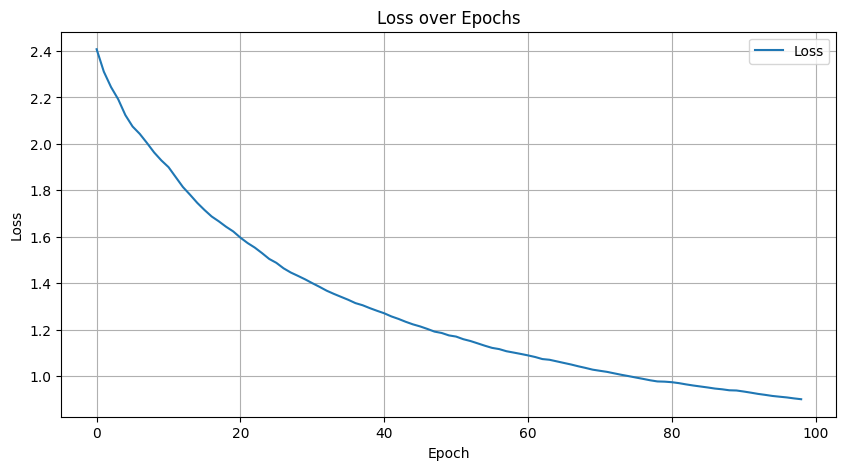

Epoch 9900/10000, Loss: 0.0418


In [24]:
# 여기에 코드 작성
batch_size = 100
num_epochs = 10000

losses = []
loss_average_list = []
for epoch in range(num_epochs):
    x, target, _ = generate_batch(batch_size=batch_size)
    x = torch.tensor(x, dtype=torch.float32)
    target = torch.tensor(target, dtype=torch.long)
    optimizer.zero_grad()
    output = model(x)
    loss = nn.CrossEntropyLoss()(output.view(-1, 12), target.view(-1))
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    if epoch % batch_size == 0 and epoch > 0:
        loss_average = np.mean(losses)
        loss_average_list.append(loss_average)
        plot_loss(loss_average_list)
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss:.4f}")